In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
loader = transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor()])

In [4]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
style_pic = r"C:\Users\Hp\Desktop\Aries Style transfer\style\Oscar Florianus Bluemner - Old Canal Port.jpg"
content_pic = r"C:\Users\Hp\Desktop\Aries Style transfer\target\i.jpg"

In [6]:
style = image_loader(style_pic)
content = image_loader(content_pic)

In [7]:
unloader = transforms.ToPILImage()
plt.ion()

In [8]:
def imshow(tensor, title=None):
    # Clone the tensor to avoid changes to the original tensor
    image = tensor.cpu().clone()  
    # Remove the batch dimension
    image = image.squeeze(0)  
    # Convert the tensor to a NumPy array
    unloader = transforms.ToPILImage()  
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause to update the plot

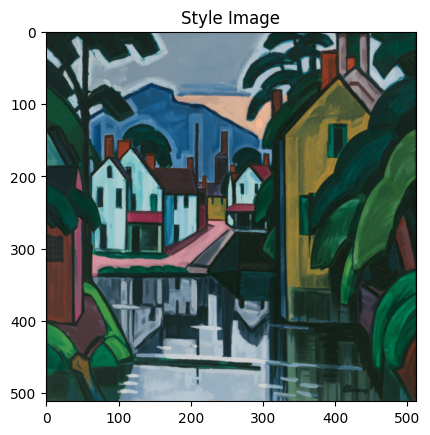

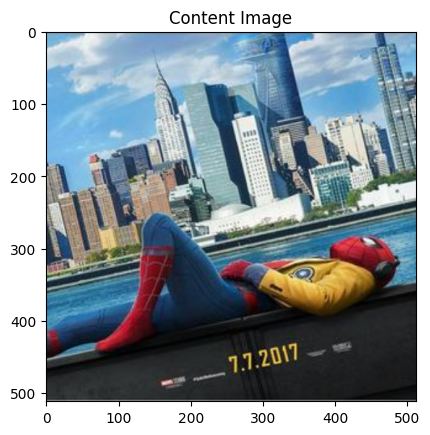

In [9]:
plt.figure()
imshow(style, title='Style Image')

plt.figure()
imshow(content, title='Content Image')

In [10]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())

    return G.div(a * b * c * d)

In [12]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [13]:
model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [14]:
model_mean = torch.tensor([0.485, 0.456, 0.406])
model_std = torch.tensor([0.229, 0.224, 0.225])

In [15]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [16]:
# desired depth layers for style and content
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [17]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,content_layers=content_layers_default,style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)
    # definiting loss arrays
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

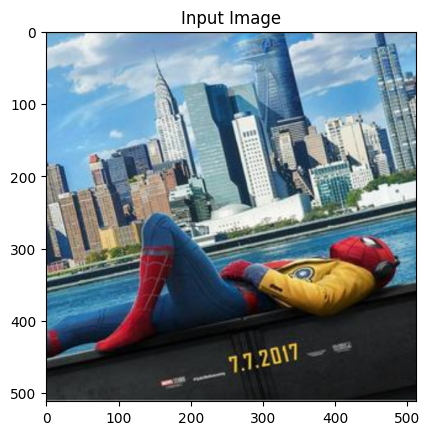

In [18]:
input_img = content.clone()
plt.figure()
imshow(input_img, title='Input Image')


In [19]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [20]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=500,style_weight=1000000, content_weight=1):
    print('BUILDING YOUR ART IMAGE .....')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('OPTIMIZING SO THAT YOU CAN GET MORE ACCURATE IMAGE :)')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

BUILDING YOUR ART IMAGE .....


c:\python\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


OPTIMIZING SO THAT YOU CAN GET MORE ACCURATE IMAGE :)
run [50]:
Style Loss : 63.259750 Content Loss: 10.757594

run [100]:
Style Loss : 25.402737 Content Loss: 11.809374

run [150]:
Style Loss : 13.846391 Content Loss: 11.286598

run [200]:
Style Loss : 9.843092 Content Loss: 10.395999

run [250]:
Style Loss : 7.298457 Content Loss: 9.887568

run [300]:
Style Loss : 5.358260 Content Loss: 9.546005

run [350]:
Style Loss : 4.038373 Content Loss: 9.216352

run [400]:
Style Loss : 3.101222 Content Loss: 8.933016

run [450]:
Style Loss : 2.439842 Content Loss: 8.684990

run [500]:
Style Loss : 2.020204 Content Loss: 8.473133



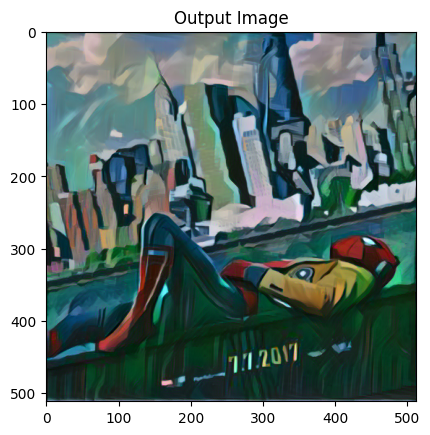

In [21]:
# Test Model run
output = run_style_transfer(model,model_mean,model_std,content, style, input_img)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

In [22]:
def for_user(target,style,model=model,model_mean=model_mean,model_std=model_std):
    # Example of path is r"C:\Users\Hp\Desktop\Aries Style transfer\style\Oscar Florianus Bluemner - Old Canal Port.jpg"
    # please include a r in beginning
    #Target is the path of image which you have to edit
    #Style is the path of image that your style is inspired
    style_img = image_loader(style)
    content_img = image_loader(target)

    print("Prieview of the image you have uploaded")
    plt.figure()
    imshow(style_img, title='Style Image')
    plt.figure()
    imshow(content_img, title='Content Image')

    input_img = content_img.clone()
    final_image = run_style_transfer(model,model_mean,model_std,content_img, style_img, input_img)

    print("Printing your final transformed image")
    plt.figure()
    imshow(final_image, title='Output Image')
    plt.ioff()
    plt.show()

Prieview of the image you have uploaded


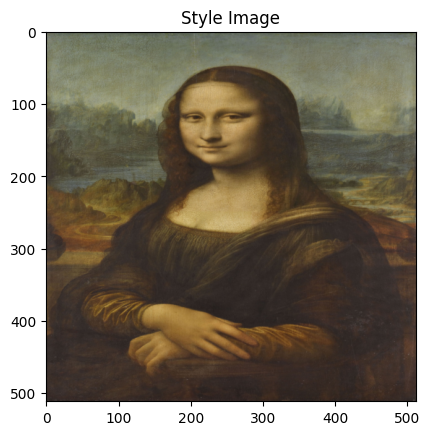

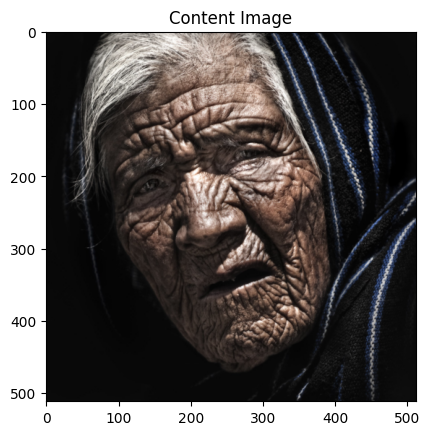

BUILDING YOUR ART IMAGE .....
OPTIMIZING SO THAT YOU CAN GET MORE ACCURATE IMAGE :)
run [50]:
Style Loss : 18.850761 Content Loss: 12.286387

run [100]:
Style Loss : 2.015410 Content Loss: 8.231160

run [150]:
Style Loss : 0.911916 Content Loss: 6.597881

run [200]:
Style Loss : 0.633999 Content Loss: 6.220292

run [250]:
Style Loss : 0.518078 Content Loss: 6.077250

run [300]:
Style Loss : 0.455025 Content Loss: 5.995448

run [350]:
Style Loss : 0.413555 Content Loss: 5.945054

run [400]:
Style Loss : 0.388737 Content Loss: 5.911078

run [450]:
Style Loss : 0.368533 Content Loss: 5.888000

run [500]:
Style Loss : 0.352087 Content Loss: 5.872719

Printing your final transformed image


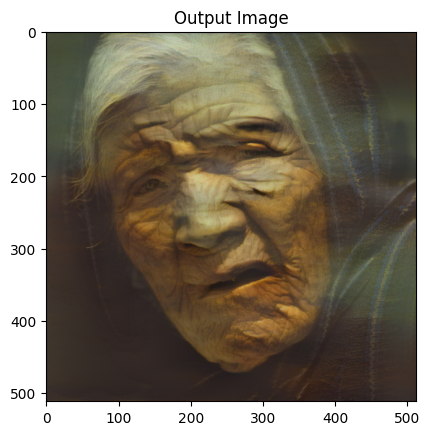

In [23]:
for_user(r"C:\Users\Hp\Desktop\Aries Style transfer\target\1 (1349).jpg",r"C:\Users\Hp\Desktop\Aries Style transfer\style\Leonardo Da Vinci - Portrait of Lisa Gherardini.jpg")